Metrics for MNIST

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [83]:
# converting to square

def flat_to_square(actual, ideal):
    sqrt_size = int(actual.shape[1] ** 0.5)
    first_layer_size = actual.shape[0]

    actual_structural = actual.reshape(first_layer_size, sqrt_size, sqrt_size)
    ideal_structural = ideal.reshape(first_layer_size, sqrt_size, sqrt_size)
    return actual_structural, ideal_structural

# MSE
def mse(actual, ideal):
    return np.mean((actual.flatten() - ideal.flatten()) ** 2)

# Cosine Similarity
def cos_sim(actual, ideal):
    actual_flat = actual.flatten()
    ideal_flat = ideal.flatten()
    dot_product = np.dot(actual_flat, ideal_flat)
    norm_actual = np.linalg.norm(actual_flat)
    norm_ideal = np.linalg.norm(ideal_flat)
    return dot_product / (norm_actual * norm_ideal) if (norm_actual * norm_ideal) != 0 else 0

# peak signal to noise ratio
def psnr(actual, ideal):
    return skimage.metrics.peak_signal_noise_ratio(actual, ideal)

# Structural Similarity Index (SSIM)
# need to specify data_range for this method
def ssim(actual_structural, ideal_structural): 
    combined = np.concatenate((actual_structural.flatten(), ideal_structural.flatten()))
    data_range = np.max(combined) - np.min(combined)

    temp = skimage.metrics.structural_similarity(actual_structural, ideal_structural, data_range=data_range)
    return temp

# Infinity norm
def inf_norm(actual, ideal):
    D = actual - ideal
    return np.linalg.norm(D, ord=np.inf)

def compare_gradients(approx, ideal, metric_func):
    return metric_func(approx, ideal)

In [84]:
def plot_grad_dist(metrics, p_vals, get_grad_dist_func, dataset_name):

    data_set = dataset_name
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist_func(metric_func, p_vals)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(p_vals, grad_dists, label=metric_func.__name__)
        ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('p values')
        ax.set_xscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.savefig(f'callback_plots/sim_vs_p_{data_set}.png')
    plt.show()

In [85]:
def get_grad_dist_mnist(metric_func, p_vals):
    #p_grad_dist = np.zeros_like(p_vals)
    #p_grad_stds = np.zeros_like(p_vals)
    #run_num = 0
    num_p = len(p_vals)
    num_tasks = 5
    num_runs = 10

    model_weight_types = ['weight', 'bias']
    model_layer_names = ['grad_layers.0']
    num_grad_files = len(model_weight_types)*len(model_layer_names)

    data_tensor = np.zeros((num_p, num_runs, num_tasks, num_grad_files))
    for p_index, p in enumerate(p_vals):
        for run in range(num_runs):
            for task in range(num_tasks):
                grad_index = 0
                for model_layer_prefix in model_layer_names: # loop over model layer names
                    for weight_type in model_weight_types: # loop over types of weights
                        weight_name = f'{model_layer_prefix}.{weight_type}.npy'
                        p_grad_actual_arr = np.load(f'models/mnist_split/{p}/run_{run}/ideal_grad_task_{task}/{weight_name}')
                        p_grad_ideal_arr =  np.load(f'models/mnist_split/1/train/task_{task}/{weight_name}')

                        # print(f"max for run#{run}, task#{task} is: {np.max(p_grad_actual_arr)}")

                        data_tensor[p_index, run, task, grad_index] = compare_gradients(p_grad_actual_arr, p_grad_ideal_arr, metric_func)
                        grad_index += 1

    data = np.mean(data_tensor, axis = -1) # avg over grad files
    data = np.mean(data, axis = -1) # avg over tasks
    p_mean = np.mean(data, axis = -1) # avg over runs
    p_std = np.std(data, axis = -1)

    return p_mean, p_std

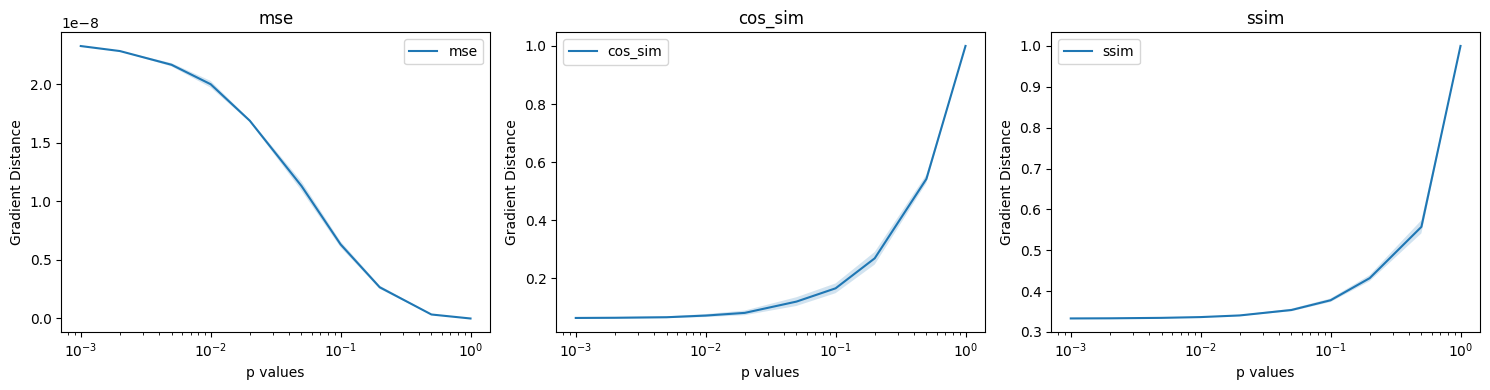

In [86]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

plot_grad_dist(metrics_list, p_values, get_grad_dist_mnist, 'MNIST')

### Metrics of similarity vs accuracy for MNIST

In [74]:
def plot_grad_dist_acc_mnist(metrics, p_vals, get_grad_dist_func):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    avg_acc_arr = np.zeros_like(p_vals)

    for i, p in enumerate(p_vals):
        avg_acc_arr[i] = np.mean(np.load(f'models/mnist_split/{p}/train/acc.npy'))

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist_func(metric_func, p_vals)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(avg_acc_arr, grad_dists, label=metric_func.__name__)
        ax.fill_between(avg_acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('accuracy')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.savefig('callback_plots/sim_vs_acc_MNIST.png')
    plt.show()


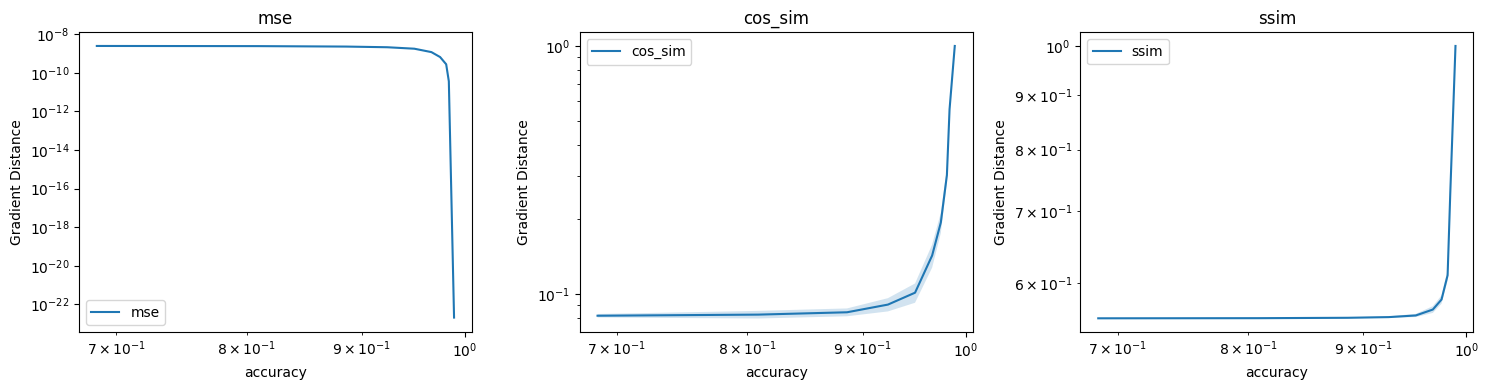

In [75]:
plot_grad_dist_acc_mnist(metrics_list, p_values, get_grad_dist_mnist)

### Metrics for CIFAR

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def get_grad_dist_cifar(metric_func, p_vals):
    num_p = len(p_vals)
    num_tasks = 5
    num_runs = 10

    model_weight_types = ['weight']
    model_layer_names = ['grad_conv_block.0', 'grad_conv_block.2', 'grad_conv_block.6', 'grad_conv_block.8']#, 
                         #'grad_linear_block.0', 'grad_out_block']
    num_grad_files = len(model_weight_types)*len(model_layer_names)

    data_tensor = np.zeros((num_p, num_runs, num_tasks, num_grad_files))
    for p_index, p in enumerate(p_vals):
        for run in range(num_runs):
            for task in range(num_tasks):
                grad_index = 0
                for model_layer_prefix in model_layer_names: # loop over model layer names
                    for weight_type in model_weight_types: # loop over types of weights
                        weight_name = f'{model_layer_prefix}.{weight_type}.npy'
                        p_grad_actual_arr = np.load(f'models/cifar10_split/{p}/run_{run}/ideal_grad_task_{task}/{weight_name}')
                        p_grad_ideal_arr =  np.load(f'models/cifar10_split/1/train/task_{task}/{weight_name}')

                        data_tensor[p_index, run, task, grad_index] = compare_gradients(p_grad_actual_arr, p_grad_ideal_arr, metric_func)
                        grad_index += 1

    data = np.mean(data_tensor, axis = -1) # avg over grad files
    data = np.mean(data, axis = -1) # avg over tasks
    p_mean = np.mean(data, axis = -1) # avg over runs
    p_std = np.std(data, axis = -1)

    return p_mean, p_std


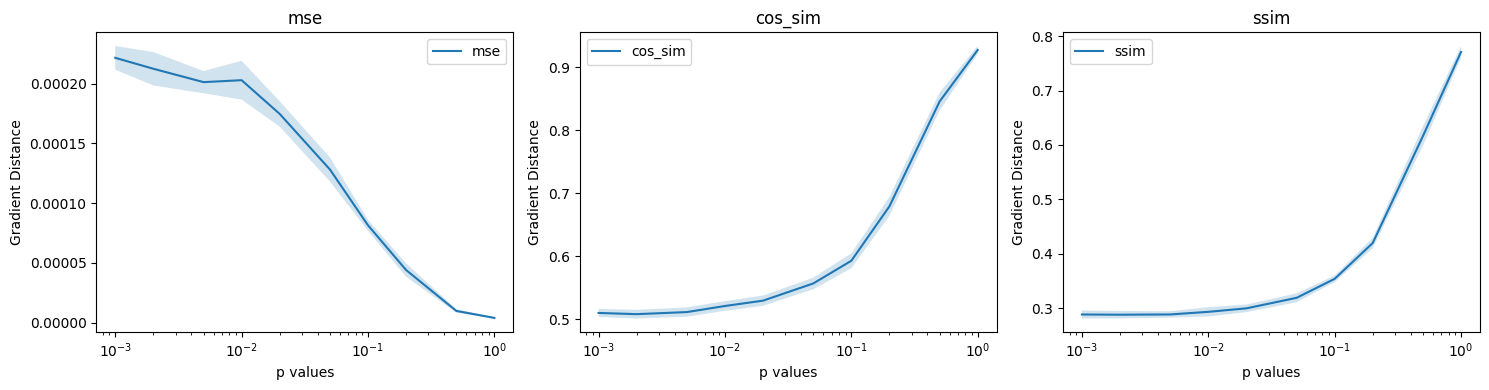

In [77]:
metrics_list = [mse, cos_sim, ssim]
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

plot_grad_dist(metrics_list, p_values, get_grad_dist_cifar, "CIFAR")



### Metrics for CIFAR against accuracy

In [78]:
def plot_grad_dist_acc_cifar(metrics, p_vals, get_grad_dist_func):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    avg_acc_arr = np.zeros_like(p_vals)

    for i, p in enumerate(p_vals):
        avg_acc_arr[i] = np.mean(np.load(f'models/cifar10_split/{p}/train/acc.npy'))

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist_func(metric_func, p_vals)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(avg_acc_arr, grad_dists, label=metric_func.__name__)
        ax.fill_between(avg_acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('accuracy')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.savefig('callback_plots/sim_vs_acc_CIFAR.png')
    plt.show()


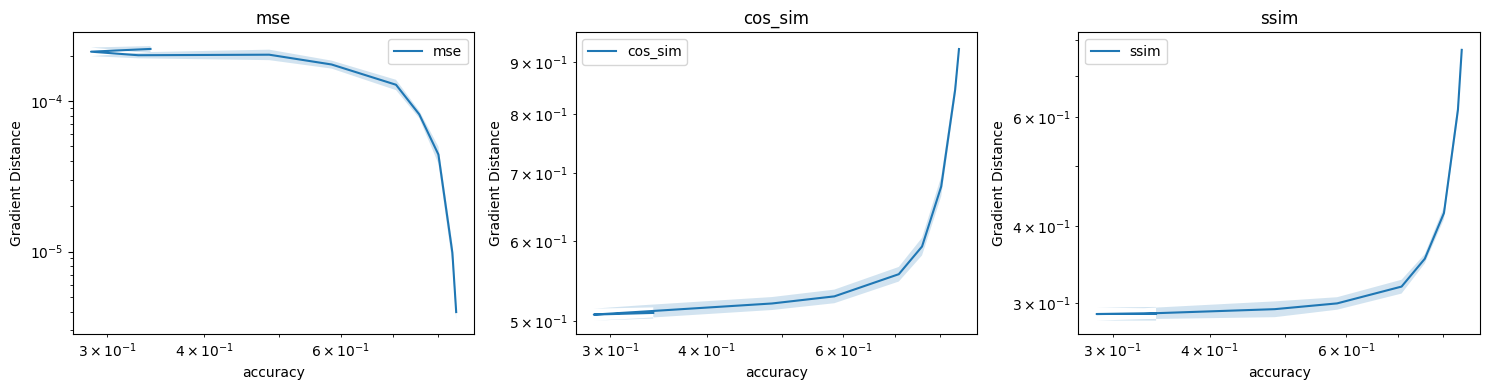

In [79]:
plot_grad_dist_acc_cifar(metrics_list, p_values, get_grad_dist_cifar)

In [80]:
print(f"0.001: {np.load(f'models/cifar10_split/0.001/train/acc.npy')}")
print(f"0.002: {np.load(f'models/cifar10_split/0.002/train/acc.npy')}")
print(f"0.005: {np.load(f'models/cifar10_split/0.005/train/acc.npy')}")
print(f"0.01: {np.load(f'models/cifar10_split/0.01/train/acc.npy')}")


0.001: [0.7785     0.3415     0.23366667 0.184      0.1675    ]
0.002: [0.5575 0.282  0.218  0.193  0.1786]
0.005: [0.573      0.31975    0.25666667 0.246      0.2486    ]
0.01: [0.813      0.48325    0.37066667 0.36325    0.3958    ]


The weird thing at low accuracy for MSE makes sense since p=0.002 and 0.005 have strangely low accuracy compared to p=0.001